# Bananas

---

In this notebook, we will train a DQN agent using the Unity ML-Agents environment.

### 1. Import packages

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the read me file and follow the installation instructions under requirements [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Instantiate the Environment

Initialize the environment in the code cell below.

In [2]:
env = UnityEnvironment(file_name="/home/pablo/deep-reinforcement-learning/p1_navigation/Banana_Linux/Banana.x86_64", 
                       no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

Initialize the agent in the code cell below

### 3. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 4. Take Random Actions in the Environment

In the next code cell, we show how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  

Of course, as part of the project, we change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment

In [6]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


If finished, you can close the environment.

In [7]:
finished = False
if( finished ):
    env.close()

### 5. Reset the environment

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]

### 6. Instantiate the Agent

Initialize the agent in the code cell below.

In [16]:
from dqn_agent import Agent
state_size = 37
action_size = 4
hidden_layers = [64, 64, 32]
agent = Agent(state_size=state_size, action_size=action_size, hidden_layers=hidden_layers, seed=0)

In [7]:
print(agent.qnetwork_local)

QNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
  (output): Linear(in_features=32, out_features=4, bias=True)
)


### 7. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Alternatively, you can skip to the next step below (**4. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.

Episode 100	Average Score: 0.92
Episode 200	Average Score: 4.50
Episode 300	Average Score: 7.56
Episode 400	Average Score: 10.94
Episode 500	Average Score: 11.71
Episode 562	Average Score: 13.02
Environment solved in 462 episodes!	Average Score: 13.02


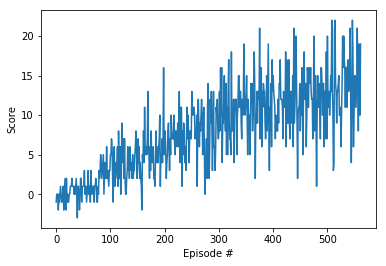

In [8]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 8. Save the Agent weights

Run the code below to save the weights of the agent's network.

In [ ]:
checkpoint = {'input_size': state_size,
              'output_size': action_size,
              'hidden_layers': [each.out_features for each in agent.qnetwork_local.hidden_layers],
              'state_dict': agent.qnetwork_local.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

### 9. Watch a Smart Agent!

Run the next code to load the trained weights from file and watch a smart agent

In [19]:
# load smart agent
def load_agent(filepath):
    checkpoint = torch.load(filepath)
    agent = Agent(state_size=checkpoint['input_size'], action_size=checkpoint['output_size'], 
              hidden_layers=checkpoint['hidden_layers'], seed=0)
    agent.qnetwork_local.load_state_dict(checkpoint['state_dict'])
    
    return agent

saved_agent = load_agent('checkpoint.pth')

In [25]:
print(saved_agent.qnetwork_local)

QNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
  (output): Linear(in_features=32, out_features=4, bias=True)
)


In [ ]:
total_reward = 0
for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name]
    for j in range(200):
        action = agent.act(state)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        total_reward += reward
        done = env_info.local_done[0]
        if done:
            break 
            
print(total_reward)
env.close()